In [7]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_health = pd.read_csv("./Data/체질검사.CSV",engine="python")
ds_health.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


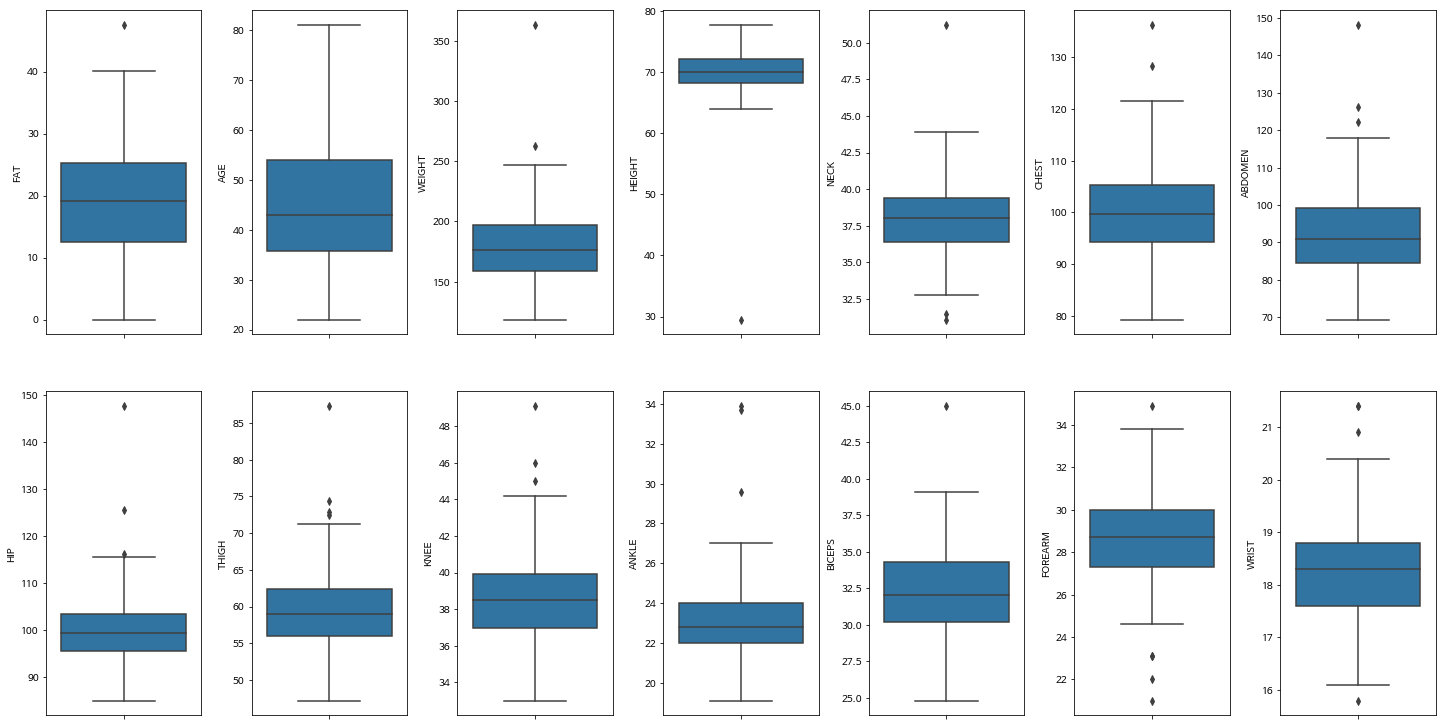

In [8]:
# 이상치 확인
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in ds_health.items():
    sns.boxplot(y=k, data=ds_health, ax=axs[index])
    index+=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

     FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  \
78  32.9   44   205.0    29.5  36.6  106.0    104.3  115.5   70.6  42.5   

    ANKLE  BICEPS  FOREARM  WRIST  
78   23.7    33.6     28.7   17.4  


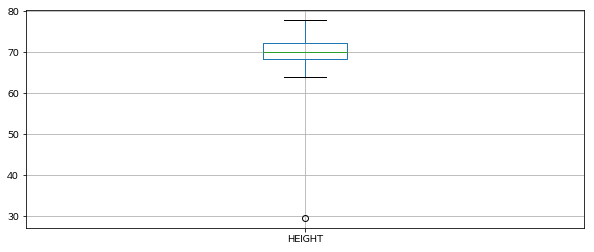

In [9]:
ds_health[['HEIGHT']].boxplot(figsize=(10,4))
print(ds_health.loc[ds_health.HEIGHT<40,:])
ds_health =ds_health.drop(78,0)

In [10]:
# 목표변수, 설명변수 역할 지정
ds_health_y = ds_health["FAT"]
ds_health_x= ds_health.drop("FAT",axis=1,inplace =False)

print("목표변수 데이터 크기: {}".format(ds_health_y.shape))
print("설명변수 데이터 크기: {}",format(ds_health_x.shape))

목표변수 데이터 크기: (251,)
설명변수 데이터 크기: {} (251, 13)


In [11]:
scaler = StandardScaler()
# 데이터 표준화 변환
scaler.fit_transform(ds_health_x)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(ds_health_x)
print("Scaled Data :\n {}".format(X_scaled[:5].round(3)))
print("Shape:\n {}".format(X_scaled.shape))

Scaled Data :
 [[ 0.088  6.282  0.743  5.435  4.202  5.168  6.744  5.371  4.387  3.836
   4.216  0.166  3.398]
 [-1.42  -0.369  0.36   0.042 -0.926 -1.246 -0.753 -0.396 -0.99   0.826
  -1.082  0.661  0.608]
 [ 1.913 -0.036 -0.694  0.289  0.142  0.232 -0.217 -0.838 -0.115 -0.767
  -0.486 -1.467  0.608]
 [ 0.961 -1.059 -1.748 -1.152 -0.143 -0.568 -1.373 -1.223 -1.49  -1.062
  -0.188 -0.675 -1.43 ]
 [ 0.485  1.369 -2.419  1.318  2.255  2.751  1.826  0.603 -0.698  0.295
   0.805  0.216  0.179]]
Shape:
 (251, 13)


C:\Users\admin1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin1\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\admin1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin1\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
pca = PCA(n_components=13)
x_pca = pca.fit_transform(X_scaled)
print("PCA Data :\n {}".format(x_pca[:5]))
print("PCA Data :\n {}".format(x_pca.shape))
a = []
for i in range(1,14):
    a.append("Prin"+str(i))
ds_x_pca = pd.DataFrame(x_pca ,columns=a)

PCA Data :
 [[15.12029813  1.00206415  1.75978137  3.35545706  0.65451447  1.92153867
   0.75258225  0.21675429 -0.72206996  0.67635844  1.0688448  -0.54740651
   0.64531284]
 [-1.20418768 -1.76674693 -0.76870836 -1.01150641  0.98257263  0.80576534
  -0.83661176 -0.58902947  0.02523989  0.38164042 -0.1460247  -0.06024081
   0.20142252]
 [-0.78753078  2.36826844 -0.80110535  0.78472728 -0.40501637  0.72851024
   0.27838462 -0.12991225  0.05016993 -0.25141786  0.16783466 -0.10127254
   0.17545847]
 [-3.35037363  1.65056258  0.81334999 -0.41740274  0.23785803 -0.42782817
   0.0726885   0.89903202  0.2295106  -0.24849562 -0.2453089  -0.06475157
   0.13486273]
 [ 3.00210885  2.78769467  2.54879728  0.39873462  0.83896736  0.66543815
  -1.27071052  0.6598823   0.53969422  0.30366247  0.55581843  0.14541659
   0.016866  ]]
PCA Data :
 (251, 13)


In [13]:
ds_pca = pd.DataFrame()
ds_pca["Prin"] = [I for I in range(1,14)]
ds_pca["EigenValues"] = pca.explained_variance_
ds_pca["EigenValueRatio"] = pca.explained_variance_ratio_
ds_pca["CumsumEigenValueRatio"] = np.cumsum(pca.explained_variance_ratio_)
ds_pca.round(3)

,Prin,EigenValues,EigenValueRatio,CumsumEigenValueRatio
0,1,8.215,0.629,0.629
1,2,1.435,0.110,0.739
2,3,0.866,0.066,0.806
3,4,0.677,0.052,0.857
4,5,0.559,0.043,0.900
5,6,0.317,0.024,0.925
6,7,0.272,0.021,0.945
7,8,0.247,0.019,0.964
8,9,0.184,0.014,0.978
9,10,0.134,0.010,0.989


In [15]:
ds_feature = pd.DataFrame({"Feature": ds_health_x.columns})
ds_eigenvectors = pd.concat([ds_feature,
pd.DataFrame(pca.components_,columns=a)],axis=1)
ds_eigenvectors


,Feature,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7,Prin8,Prin9,Prin10,Prin11,Prin12,Prin13
0,AGE,0.006393,0.342240,0.160462,0.302803,0.311267,0.306833,0.324507,0.308592,0.307661,0.229732,0.295997,0.247694,0.278256
1,WEIGHT,0.734163,-0.016604,-0.481182,0.127605,0.226243,0.269331,-0.012057,-0.129340,-0.072590,-0.213589,-0.019754,-0.093735,0.110660
2,HEIGHT,-0.443109,0.039382,-0.554677,-0.021809,0.139247,0.179186,0.193684,0.316148,-0.117243,-0.309319,0.158774,0.004867,-0.412728
3,NECK,0.055947,0.125805,0.123490,-0.196450,0.062863,0.222147,0.250321,0.141037,0.223883,0.208666,-0.303494,-0.750406,-0.206067
4,CHEST,-0.075248,-0.106126,-0.535160,-0.077257,-0.050478,-0.085341,-0.068573,0.004711,-0.054311,0.811330,-0.008953,0.038527,0.115694
5,ABDOMEN,-0.293210,0.037862,-0.056151,0.560643,-0.015045,-0.088484,-0.027375,-0.028608,-0.373805,-0.085398,0.014455,-0.479849,0.456081
6,HIP,0.178274,-0.122765,-0.100510,-0.155125,-0.393603,-0.260267,-0.019565,0.290518,0.295143,-0.117103,0.635631,-0.288699,0.152771
7,THIGH,0.114441,0.078479,0.251036,0.045186,0.231853,0.061005,-0.118666,-0.238083,-0.412825,0.252091,0.577876,-0.161703,-0.439748
8,KNEE,-0.151433,0.069838,0.016925,-0.699919,0.255569,0.138784,0.134372,-0.133976,-0.278775,-0.104578,0.140532,-0.038250,0.501569
9,ANKLE,0.274064,0.031591,0.140934,-0.037430,-0.421296,0.068964,0.351530,0.453067,-0.588470,0.081987,-0.125486,0.149629,-0.019623


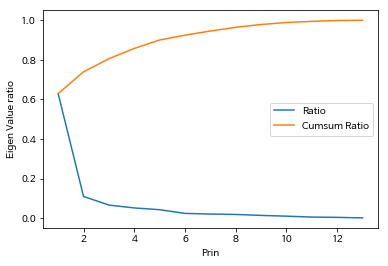

In [16]:
# 고유값 비율 그래프 생성
plt.plot(ds_pca["Prin"], ds_pca["EigenValueRatio"],label ="Ratio")
# 누적된 고유값 비율 그래프 생성
plt.plot(ds_pca["Prin"], ds_pca["CumsumEigenValueRatio"], label="Cumsum Ratio")
# 그래프 label, legend 설정
plt.ylabel("Eigen Value ratio")
plt.xlabel("Prin")
plt.legend(loc="best")